# Time Series Project - monthly housing sales by zip code

## Dataset information

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

- **_RegionID_**: Unique index, 58196 through 753844
- **_RegionName_**: Unique Zip Code, 1001 through 99901
- **_City_**: City in which the zip code is located
- **_State_**: State in which the zip code is located
- **_Metro_**: Metropolitan Area in which the zip code is located
- **_CountyName_**: County in which the zip code is located
- **_SizeRank_**: Numerical rank of size of zip code, ranked 1 through 14723
- **_1996-04 through 2018-04_**: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


Some ideas for exploration:

1. Look at ROI for each zip code, over the whole dataset, avg for each year, 3 year avg, 5 year avg, 10 year avg
2. Plot median sales price against ROI to get quadrants for comparison
3. Which zips have highest and lowest ROI?
4. Business case - choose highest ROI for small investors

## Data Preprocessing

### Import and basic info

**Output** - zillow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from user_functions import *
from datetime import datetime

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

'''font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!'''

"font = {'family' : 'normal',\n        'weight' : 'bold',\n        'size'   : 22}\n\nmatplotlib.rc('font', **font)\n\n# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!"

In [3]:
zillow = pd.read_csv('zillow_data.csv')
zillow.info()
# I see 4 string object columns, not sure why 49 are int and others float.
# Most will be changed to datetime
# Zip codes are actually not continuous so maybe they should be strings
# Don't know if RegionID has any meaning, seems unneeded if zip codes are unique.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# Data appears to be sorted by SizeRank, largest to smallest
# I see some Nan values in Metro
# And some 4 digit zip codes which I assume should start with a zero
zillow.tail(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
14713,59187,3765,Haverhill,NH,Claremont,Grafton,14714,80800.0,80100.0,79400.0,...,119800,120000,120800,121600,122600,123400,124400,125500,126600,127500
14714,94711,84781,Pine Valley,UT,St. George,Washington,14715,135900.0,136300.0,136600.0,...,241100,243200,244300,248900,254600,257600,258000,260600,264700,266800
14715,62556,12429,Esopus,NY,Kingston,Ulster,14716,78300.0,78300.0,78200.0,...,164200,166600,170000,171000,170700,171300,172400,173600,175800,177500
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14717,62697,12720,Bethel,NY,NaN,Sullivan,14718,62500.0,62600.0,62700.0,...,122200,122700,122300,122000,122200,122800,123200,123200,120700,117700
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400
14722,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,176400.0,176300.0,176100.0,...,333800,336400,339700,343800,346800,348900,350400,353000,356000,357200


In [6]:
# Can see missing values in Metro
zillow.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [7]:
# There will be lots of other missing values in the time series data
zillow.isna().sum().sum()

157934

### Analyze 'RegionID'

All unique, cast to string

In [8]:
# Starting analysis of first variable, RegionID
# 14723 unique values
print(zillow.RegionID.value_counts())
print(zillow.RegionID.nunique())
print(zillow.RegionID.min())
print(zillow.RegionID.max())

73724     1
70551     1
99221     1
76688     1
82829     1
         ..
71176     1
91654     1
65029     1
100380    1
98304     1
Name: RegionID, Length: 14723, dtype: int64
14723
58196
753844


In [9]:
zillow[zillow.RegionID >= 200000]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
444,417444,85142,Queen Creek,AZ,Phoenix,Pinal,445,117400.0,115500.0,113800.0,...,281200,283700,286200,288200,289900,291700,293700,296300,299700,302200
750,399576,33578,Riverview,FL,Tampa,Hillsborough,751,74700.0,74200.0,73800.0,...,189600,190100,190400,191400,192900,194200,195000,196200,197600,198800
863,417437,85122,Casa Grande,AZ,Phoenix,Pinal,864,82700.0,83500.0,84300.0,...,152600,155000,157200,158400,158700,158900,159300,160400,162600,164700
926,399724,77407,Richmond,TX,Houston,Fort Bend,927,119800.0,119600.0,119700.0,...,247100,247200,247100,247000,246600,246700,247500,248900,249600,249500
1101,399638,78665,Round Rock,TX,Austin,Williamson,1102,160700.0,160300.0,160100.0,...,258000,257400,257700,258400,258900,258900,258900,259500,260100,259900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12263,399644,80927,Colorado Springs,CO,Colorado Springs,El Paso,12264,147800.0,148500.0,149100.0,...,335900,335700,335200,334700,334900,336200,339400,344900,351500,355300
12407,399666,89034,Mesquite,NV,Las Vegas,Clark,12408,196000.0,196000.0,195900.0,...,289400,294500,299800,304700,308100,311700,315500,319500,323600,326600
13498,417445,85145,Marana,AZ,Tucson,Pima,13499,NaN,NaN,NaN,...,141000,143800,145900,146600,147400,148900,150600,151800,152300,152700
14181,399514,3285,Thornton,NH,Claremont,Grafton,14182,92000.0,91800.0,91500.0,...,200500,204900,208600,211600,213200,215000,217100,219500,221500,222400


In [10]:
# It doesn't seem to mean anything and all are unique.  Lets make them strings.
zillow.RegionID = zillow.RegionID.astype('string')

In [11]:
zillow.RegionID.unique()

<StringArray>
['84654', '90668', '91982', '84616', '93144', '91733', '61807', '84640',
 '91940', '97564',
 ...
 '59187', '94711', '62556', '99032', '62697', '58333', '59107', '75672',
 '93733', '95851']
Length: 14723, dtype: string

### Analyze 'Region Name'

**Output** - 

Cast to string, add 0 to 4 digit zip codes

In [12]:
# Now look at RegionName, this is the zip code
zillow.RegionName.value_counts() # 14723 unique values

55324    1
74561    1
73538    1
31546    1
82070    1
        ..
75182    1
55343    1
1450     1
73129    1
65536    1
Name: RegionName, Length: 14723, dtype: int64

In [13]:
# All zip codes are unique.  I will cast to string and add 0 to the four digit one.
zillow.RegionName = zillow.RegionName.astype('string')

In [14]:
for i in range(len(zillow)):
    zillow.RegionName[i] = zillow.RegionName[i].rjust(5, '0')

In [15]:
zillow.RegionName.min()

'01001'

In [16]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(47), object(4), string(2)
memory usage: 30.6+ MB


In [17]:
zillow[['RegionName', 'State']].sort_values(by=['RegionName'])

,RegionName,State
5850,01001,MA
4199,01002,MA
11213,01005,MA
6850,01007,MA
14547,01008,MA
...,...,...
4526,99709,AK
8438,99712,AK
4106,99801,AK
8658,99835,AK


### Analyze 'City'



In [18]:
# There are 7554 unique values.
zillow.City.nunique()

7554

### Analyze 'State'



In [19]:
zillow.State.nunique()

51

In [20]:
# Includes DC
zillow.State.unique()

array(['IL', 'TX', 'NY', 'CA', 'FL', 'TN', 'NC', 'GA', 'DC', 'MO', 'OK',
       'AZ', 'NJ', 'MD', 'VA', 'WA', 'OH', 'MI', 'MA', 'KS', 'NM', 'CT',
       'NV', 'PA', 'CO', 'OR', 'IN', 'SC', 'KY', 'AR', 'ND', 'MN', 'AL',
       'DE', 'LA', 'MS', 'ID', 'MT', 'HI', 'WI', 'UT', 'ME', 'SD', 'WV',
       'IA', 'RI', 'NE', 'WY', 'AK', 'NH', 'VT'], dtype=object)

In [21]:
zillow[zillow['State']=='DC']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
29,66126,20002,Washington,DC,Washington,District of Columbia,30,94300.0,94000.0,93700.0,...,662800,668000,672200,673100,674600,678200,680900,683000,687500,691300
33,66133,20009,Washington,DC,Washington,District of Columbia,34,178800.0,179200.0,179600.0,...,1020000,1027500,1034300,1040500,1047400,1055400,1065900,1076400,1081000,1078200
181,66135,20011,Washington,DC,Washington,District of Columbia,182,118900.0,118500.0,118200.0,...,582200,586200,591200,593200,591200,589500,590800,599100,611400,619100
246,66142,20019,Washington,DC,Washington,District of Columbia,247,91300.0,91000.0,90600.0,...,291100,296300,302500,306700,308800,310800,313400,314100,311800,308600
258,66125,20001,Washington,DC,Washington,District of Columbia,259,92000.0,92600.0,93200.0,...,765000,768800,771200,773300,777600,780500,781600,785500,791400,793300
402,66143,20020,Washington,DC,Washington,District of Columbia,403,104500.0,103800.0,103000.0,...,314700,317600,321800,324500,324800,324900,324900,327300,332800,337000
1263,66132,20008,Washington,DC,Washington,District of Columbia,1264,450100.0,448200.0,446300.0,...,1501600,1508800,1509700,1506000,1509100,1514300,1519400,1527900,1539600,1545900
1448,66127,20003,Washington,DC,Washington,District of Columbia,1449,130000.0,130100.0,130200.0,...,801000,807200,811900,813400,814600,814600,815300,817300,820200,820200
1707,66151,20032,Washington,DC,Washington,District of Columbia,1708,85700.0,85500.0,85400.0,...,288100,293400,297800,301500,303700,304000,304600,306800,308200,307400
2066,66139,20016,Washington,DC,Washington,District of Columbia,2067,362000.0,361200.0,360300.0,...,1202900,1198700,1196400,1190400,1184800,1183600,1186600,1190000,1196000,1199500


### Analyze 'Metro'

Fillna with None

In [22]:
print(zillow.Metro.value_counts())
print(zillow.Metro.nunique())

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
                                 ... 
Clarksdale                          1
Fredericksburg                      1
Los Alamos                          1
Connersville                        1
North Platte                        1
Name: Metro, Length: 701, dtype: int64
701


In [23]:
zillow.Metro[151]

nan

In [24]:
zillow.Metro.fillna('None', inplace=True)

In [25]:
zillow.Metro.value_counts()

None                              1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
                                  ... 
Clarksdale                           1
Fredericksburg                       1
Los Alamos                           1
Connersville                         1
North Platte                         1
Name: Metro, Length: 702, dtype: int64

### Analyze 'CountyName'



In [26]:
zillow.CountyName.value_counts()

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
              ... 
Morehouse        1
Karnes           1
Rosebud          1
Kinney           1
Los Alamos       1
Name: CountyName, Length: 1212, dtype: int64

In [27]:
zillow.CountyName.isna().sum()

0

### Analyze 'SizeRank'



In [28]:
zillow.SizeRank.unique()

array([    1,     2,     3, ..., 14721, 14722, 14723], dtype=int64)

### Analyze missing sales values

In [29]:
# 1039 zip codes don't have full data
zillow[zillow['1996-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
36,61796,10456,New York,NY,New York,Bronx,37,NaN,NaN,NaN,...,357900,357100,356500,357200,362000,368500,374100,379800,388100,394400
105,84613,60611,Chicago,IL,Chicago,Cook,106,NaN,NaN,NaN,...,1475200,1473900,1469500,1472100,1477800,1486000,1497300,1508600,1508100,1493200
156,62048,11238,New York,NY,New York,Kings,157,NaN,NaN,NaN,...,2673300,2696700,2716500,2724000,2744300,2768900,2810700,2848100,2869600,2885300
232,69533,27834,Greenville,NC,Greenville,Pitt,233,NaN,NaN,NaN,...,100100,98700,97400,96100,95900,96300,97000,98300,100200,101200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14703,94323,83821,Coolin,ID,Sandpoint,Bonner,14704,NaN,NaN,NaN,...,550500,550700,542900,539100,547100,555700,561500,558600,547800,540400
14705,79929,49768,Paradise,MI,Sault Ste. Marie,Chippewa,14706,NaN,NaN,NaN,...,86700,86900,87000,87200,87500,88100,88100,87500,86900,86700
14706,59046,03215,Waterville Valley,NH,Claremont,Grafton,14707,NaN,NaN,NaN,...,786000,780900,774100,767800,778300,796800,808100,811600,806500,796600
14707,69681,28039,East Spencer,NC,Charlotte,Rowan,14708,NaN,NaN,NaN,...,27300,26400,25500,25100,25100,25600,25800,26600,27700,28300


In [30]:
# But all zip codes have some data
zillow[zillow['2018-04'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [31]:
# I need to find an ROI that I can compare them all on
# Find the zips with the least data
for col in reversed(zillow.columns):
    if zillow[col].isna().sum() >0:
        print(col)
        break

2014-06


In [32]:
# 56 zip codes only go back to 07-2014
zillow[zillow['2014-06'].isna()]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,02116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,None,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100
8263,88723,70647,Iowa,LA,Lake Charles,Calcasieu,8264,NaN,NaN,NaN,...,111600,117900,125300,128900,129600,130800,132100,132700,132400,132300
8338,73630,35824,Huntsville,AL,Huntsville,Madison,8339,NaN,NaN,NaN,...,217200,216800,216300,215100,215700,218200,222000,226200,230300,231800
8668,75206,39202,Jackson,MS,Jackson,Hinds,8669,NaN,NaN,NaN,...,152700,154300,155800,157500,158100,158300,158400,157900,156600,155300
8746,90561,74857,Norman,OK,Oklahoma City,Cleveland,8747,NaN,NaN,NaN,...,141800,141800,141700,141700,142000,143600,145600,145700,143900,141900
8780,78097,46327,Hammond,IN,Chicago,Lake,8781,NaN,NaN,NaN,...,75200,74600,73200,72500,72800,73200,72700,72900,74000,74400


## EDA on zip codes

In [33]:
# Create a 4 year ROI since that is the most data we have for some zips
zillow['4_yr_ROI'] = (zillow['2018-04'] - zillow['2014-07'])/(zillow['2014-07'])
zillow['4_yr_ROI']

0        0.154346
1        0.338046
2        0.134847
3        0.119294
4        0.066725
           ...   
14718    0.103903
14719    0.239297
14720    0.280230
14721    0.234256
14722    0.293266
Name: 4_yr_ROI, Length: 14723, dtype: float64

In [34]:
# Lowest values
zillow.sort_values('4_yr_ROI').head()[['RegionName','City','State','4_yr_ROI']]

,RegionName,City,State,4_yr_ROI
11391,54230,Reedsville,WI,-0.388060
12436,45390,Union City,OH,-0.335992
13485,45346,New Madison,OH,-0.282334
13078,53015,Cleveland,WI,-0.265185
4294,45331,Greenville,OH,-0.249827


In [35]:
# Highest values
zillow.sort_values('4_yr_ROI',ascending=False).head()[['RegionName','City','State','4_yr_ROI']]

,RegionName,City,State,4_yr_ROI
13409,27980,Hertford,NC,1.948770
842,30032,Candler-Mcafee,GA,1.489011
6563,15201,Pittsburgh,PA,1.261294
4554,33805,Lakeland,FL,1.233115
6105,37210,Nashville,TN,1.142857


In [36]:
# Check most recent one year ROI
zillow['recent_1_yr_ROI'] = (zillow['2018-04'] - zillow['2017-04'])/(zillow['2017-04'])
zillow['recent_1_yr_ROI']

0        0.041852
1        0.057162
2        0.030937
3        0.019103
4        0.029661
           ...   
14718   -0.010402
14719    0.162120
14720    0.104305
14721    0.121350
14722    0.100092
Name: recent_1_yr_ROI, Length: 14723, dtype: float64

In [37]:
# Lowest values
zillow.sort_values('recent_1_yr_ROI').head()[['RegionName','City','State','recent_1_yr_ROI']]

,RegionName,City,State,recent_1_yr_ROI
14618,66023,Effingham,KS,-0.218135
7286,70583,Scott,LA,-0.197955
11914,71023,Doyline,LA,-0.186260
6445,30642,Greensboro,GA,-0.170560
9457,70090,Vacherie,LA,-0.167689


In [38]:
# Highest values
zillow.sort_values('recent_1_yr_ROI',ascending=False).head()[['RegionName','City','State','recent_1_yr_ROI']]

,RegionName,City,State,recent_1_yr_ROI
4211,07106,Newark,NJ,0.508078
13409,27980,Hertford,NC,0.474385
3285,19601,Reading,PA,0.437500
3540,07103,Newark,NJ,0.435213
4309,29405,North Charleston,SC,0.431034


In [39]:
# Find avg one year ROI over past 3 years
def average_one_year_ROI(df):
    average_one_year_ROI = []
    for i in range(len(df)):
        year_1_ROI = df['recent_1_yr_ROI'][i]
        year_2_ROI = (df.iloc[i,-15] - df.iloc[i,-27])/df.iloc[i,-27]
        year_3_ROI = (df.iloc[i,-27] - df.iloc[i,-39])/df.iloc[i,-39]
        avg_ROI = (year_1_ROI + year_2_ROI + year_3_ROI)/3
        average_one_year_ROI.append(avg_ROI)
    return average_one_year_ROI    

In [40]:
zillow['avg_one_yr_ROI'] = average_one_year_ROI(zillow)

In [41]:
# Lowest values
zillow.sort_values('avg_one_yr_ROI').head()[['RegionName','City','State','avg_one_yr_ROI']]

,RegionName,City,State,avg_one_yr_ROI
11391,54230,Reedsville,WI,-0.135889
12436,45390,Union City,OH,-0.129479
13485,45346,New Madison,OH,-0.109924
13078,53015,Cleveland,WI,-0.103355
4294,45331,Greenville,OH,-0.098901


In [42]:
# Highest values
zillow.sort_values('avg_one_yr_ROI', ascending=False).head()[['RegionName','City','State','avg_one_yr_ROI','2018-04']]

,RegionName,City,State,avg_one_yr_ROI,2018-04
13409,27980,Hertford,NC,0.355009,143900
842,30032,Candler-Mcafee,GA,0.273701,135900
466,19134,Philadelphia,PA,0.268561,46600
1821,28208,Charlotte,NC,0.250809,113400
2661,33705,Saint Petersburg,FL,0.247735,177300


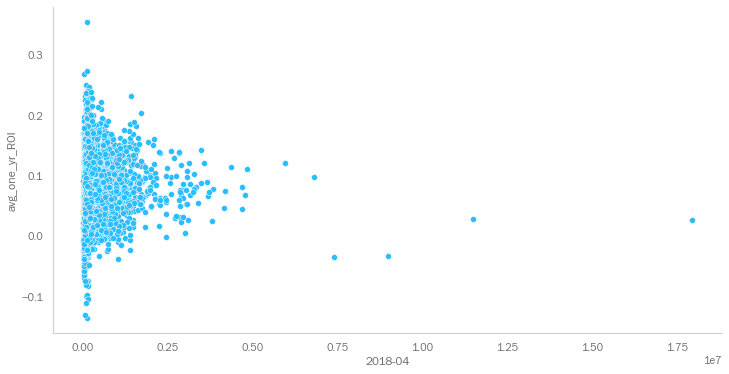

In [43]:
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI');

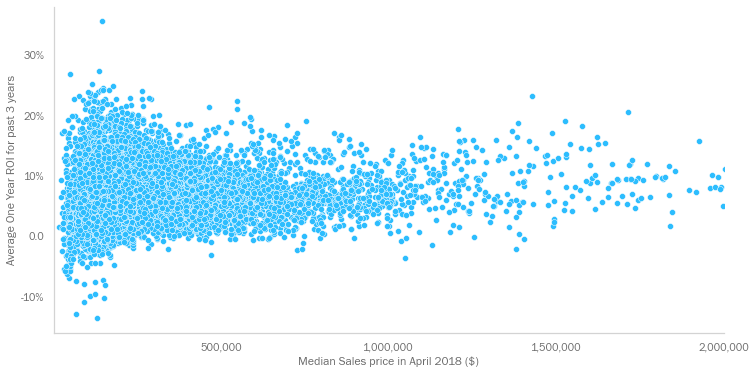

In [44]:
# Eliminate the high outliers
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,2000000)
plt.xticks([500000,1000000,1500000,2000000],['500,000','1,000,000','1,500,000','2,000,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
plt.yticks([-0.10, 0, 0.10, 0.20, 0.30], ['-10%', '0.0', '10%', '20%', '30%']);

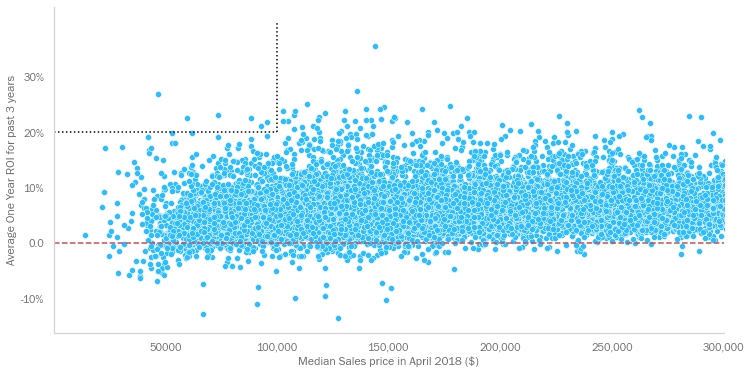

In [45]:
# Further reduce price
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,300000)
plt.xticks([50000,100000,150000,200000,250000,300000],['50000','100,000','150,000','200,000','250,000','300,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
plt.hlines(0, 0, 300000, color='r', linestyles='dashed')
plt.hlines(.20, 0, 100000, color = 'black', linestyles='dotted')
plt.vlines(100000,.2,.4,color='black', linestyles='dotted')
plt.yticks([-0.10, 0, 0.10, 0.20, 0.30], ['-10%', '0.0', '10%', '20%', '30%'])
plt.savefig('images/scatterplot.png');

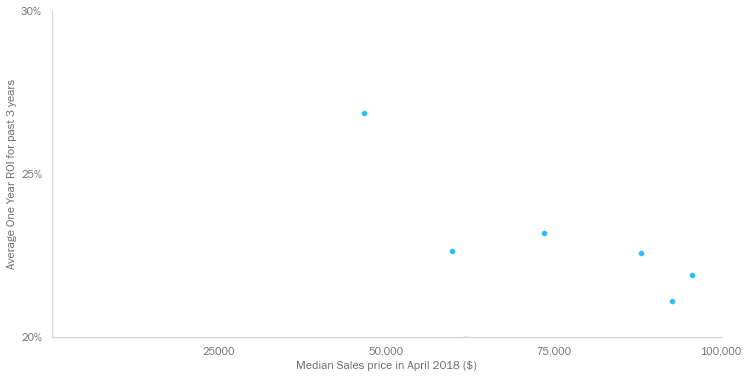

In [46]:
# Zoom in
plt.figure(figsize = (12,6))
sns.scatterplot(data=zillow, x='2018-04', y='avg_one_yr_ROI')
plt.xlim(0,100000)
plt.ylim(.20,.30)
plt.xticks([25000, 50000,75000,100000],['25000','50,000','75,000','100,000'])
plt.xlabel('Median Sales price in April 2018 ($)')
plt.ylabel('Average One Year ROI for past 3 years')
# plt.hlines(0, 0, 300000, color='r', linestyles='dashed')
# plt.hlines(.20, 0, 100000, color = 'black', linestyles='dotted')
# plt.vlines(100000,.2,.4,color='black', linestyles='dotted')
plt.yticks([0.20, 0.25, 0.30], ['20%', '25%', '30%'])
plt.savefig('images/scatterplot2.png');

## Subset data on top zip codes

In [47]:
zillow_top = zillow[(zillow['2018-04'] < 100000) & (zillow['avg_one_yr_ROI'] > 0.20)]
zillow_top

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,27600.0,27500.0,27500.0,...,39600,40600,41600,42600,44000,45700,46600,0.834646,0.259459,0.268561
1754,78022,46203,Indianapolis,IN,Indianapolis,Marion,1755,NaN,NaN,NaN,...,67000,66600,67400,69200,70600,71800,73500,1.047354,0.137771,0.231818
2199,71793,32114,Daytona Beach,FL,Daytona Beach,Volusia,2200,47700.0,48000.0,48300.0,...,85500,86700,87900,89000,90400,91900,92600,0.909278,0.169192,0.210909
3853,76575,43206,Columbus,OH,Columbus,Franklin,3854,NaN,NaN,NaN,...,69400,71800,75700,78800,81300,84500,88100,0.984234,0.409600,0.225806
4293,87104,66104,Kansas City,KS,Kansas City,Wyandotte,4294,41300.0,41200.0,41200.0,...,51600,54200,55700,55700,55900,57800,59800,0.986711,0.300000,0.226380
5682,74373,37411,Chattanooga,TN,Chattanooga,Hamilton,5683,54800.0,55000.0,55200.0,...,87400,89200,90500,91700,93500,95000,95600,0.623090,0.283221,0.219015


In [48]:
zillow_top[['RegionName', 'City','State','Metro', 'SizeRank','2018-04','avg_one_yr_ROI']]

,RegionName,City,State,Metro,SizeRank,2018-04,avg_one_yr_ROI
466,19134,Philadelphia,PA,Philadelphia,467,46600,0.268561
1754,46203,Indianapolis,IN,Indianapolis,1755,73500,0.231818
2199,32114,Daytona Beach,FL,Daytona Beach,2200,92600,0.210909
3853,43206,Columbus,OH,Columbus,3854,88100,0.225806
4293,66104,Kansas City,KS,Kansas City,4294,59800,0.226380
5682,37411,Chattanooga,TN,Chattanooga,5683,95600,0.219015


## Clustering?  

What info does this really give me?

## Convert to date types

In [49]:
# Function provided in starter notebook
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[:], format='%Y-%m')

In [50]:
zillow_top_date_df = zillow_top.iloc[:,7:-3]
zillow_top_date_df.columns = list(get_datetimes(zillow_top_date_df))
zillow_top_date_df

,1996-04-01,1996-05-01,1996-06-01,1996-07-01,1996-08-01,1996-09-01,1996-10-01,1996-11-01,1996-12-01,1997-01-01,...,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01
466,27600.0,27500.0,27500.0,27400.0,27400.0,27300.0,27300.0,27200.0,27200.0,27300.0,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
1754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66700,66700,66900,67000,66600,67400,69200,70600,71800,73500
2199,47700.0,48000.0,48300.0,48400.0,48500.0,48500.0,48500.0,48400.0,48400.0,48400.0,...,82300,83300,84300,85500,86700,87900,89000,90400,91900,92600
3853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67600,68600,68800,69400,71800,75700,78800,81300,84500,88100
4293,41300.0,41200.0,41200.0,41100.0,41000.0,40800.0,40700.0,40500.0,40500.0,40500.0,...,47300,47900,49700,51600,54200,55700,55700,55900,57800,59800
5682,54800.0,55000.0,55200.0,55400.0,55700.0,55900.0,56200.0,56400.0,56700.0,57000.0,...,82300,84500,85800,87400,89200,90500,91700,93500,95000,95600


In [66]:
zillow_top_date = pd.concat([zillow_top.iloc[:, :7], zillow_top.iloc[:, -3:], zillow_top_date_df], axis=1)
zillow_top_date

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,0.834646,0.259459,0.268561,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
1754,78022,46203,Indianapolis,IN,Indianapolis,Marion,1755,1.047354,0.137771,0.231818,...,66700,66700,66900,67000,66600,67400,69200,70600,71800,73500
2199,71793,32114,Daytona Beach,FL,Daytona Beach,Volusia,2200,0.909278,0.169192,0.210909,...,82300,83300,84300,85500,86700,87900,89000,90400,91900,92600
3853,76575,43206,Columbus,OH,Columbus,Franklin,3854,0.984234,0.409600,0.225806,...,67600,68600,68800,69400,71800,75700,78800,81300,84500,88100
4293,87104,66104,Kansas City,KS,Kansas City,Wyandotte,4294,0.986711,0.300000,0.226380,...,47300,47900,49700,51600,54200,55700,55700,55900,57800,59800
5682,74373,37411,Chattanooga,TN,Chattanooga,Hamilton,5683,0.623090,0.283221,0.219015,...,82300,84500,85800,87400,89200,90500,91700,93500,95000,95600


In [71]:
zillow_top_date.isna().sum().sum()

324

## Reshape from wide to long format

In [56]:
Philly = zillow_top_date[zillow_top_date['RegionName']=='19134']
Indy = zillow_top_date[zillow_top_date['RegionName']=='46203']
Daytona = zillow_top_date[zillow_top_date['RegionName']=='32114']
Columbus = zillow_top_date[zillow_top_date['RegionName']=='43206']
KC = zillow_top_date[zillow_top_date['RegionName']=='66104']
Chattanooga = zillow_top_date[zillow_top_date['RegionName']=='37411']

In [80]:
Indy.isna().sum().sum()

111

In [82]:
Indy.iloc[:,8:20]

,recent_1_yr_ROI,avg_one_yr_ROI,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00
1754,0.137771,0.231818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
Philly

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,4_yr_ROI,recent_1_yr_ROI,avg_one_yr_ROI,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,0.834646,0.259459,0.268561,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600


In [84]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName',
                                 'SizeRank', '4_yr_ROI', 'recent_1_yr_ROI','avg_one_yr_ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
    melted = melted.bfill() # I'm adding this to try backfill instead of dropna
    return melted.groupby('time').aggregate({'value':'mean'})

In [85]:
Philly_melted = melt_data(Philly)
Indy_melted = melt_data(Indy)
Daytona_melted = melt_data(Daytona)
Columbus_melted = melt_data(Columbus)
KC_melted = melt_data(KC)
Chattanooga_melted = melt_data(Chattanooga)
Indy_melted

,value
time,
1996-04-01,73600.0
1996-05-01,73600.0
1996-06-01,73600.0
1996-07-01,73600.0
1996-08-01,73600.0
...,...
2017-12-01,67400.0
2018-01-01,69200.0
2018-02-01,70600.0


## Visualiza time series plots

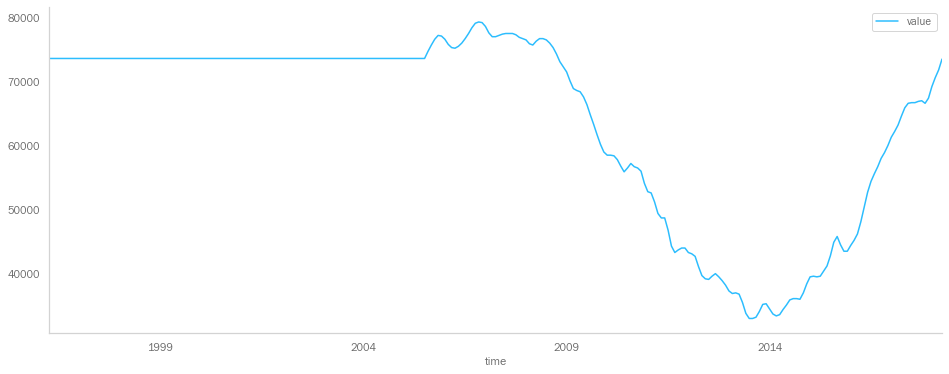

In [93]:
Indy_melted.plot(figsize = (16,6));

In [94]:
# Use pandas grouper to group values using annual frequency
year_groups = Indy_melted.groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
Indy_annual = pd.DataFrame()

for yr, group in year_groups:
    Indy_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
Indy_annual.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
Indy_annual.plot(figsize = (15,5), subplots=False, legend=True);

ValueError: Length of values (12) does not match length of index (9)

## Arima modeling

baseline, gridsearch, maybe other models


## Interpret Results / Conclusions

## Train, test, split
**Output** - X, y, X_train, X_test, y_train, y_test, train_df, test_df

In [ ]:
terry_sort3.reset_index(drop=True, inplace=True)
terry_sort3.head()

In [ ]:
X = terry_sort3.drop(columns='Arrest_Flag')
y = terry_sort3['Arrest_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
train_df = pd.concat([X_train, y_train], axis=1) 
test_df = pd.concat([X_test, y_test], axis=1)

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape)

## Perform SMOTENC for class imbalance
**Output** - X_train_SMOTE, y_train_SMOTE  (still X_test and y_test)

In [ ]:
X_train.columns # Column 12 is our one numerical column, the rest are categorical.  Need this for SMOTENC.

In [ ]:
#  One of the labs did SMOTE before the train test split.  I think maybe it is better to do after the split so I am
#   not making any changes to my test data.  However, I have learned to do it before to OHE or my dummy variables may
# get incorrect values.
from imblearn.over_sampling import SMOTENC
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())

smote = SMOTENC(random_state=10, categorical_features=[0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16])
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_SMOTE).value_counts()) 

In [ ]:
X_train_SMOTE.Weapon_Type.value_counts() # Just checking SMOTEd data values

In [ ]:
X_train_SMOTE.isna().sum() # No NaN values introduced in the SMOTE process

In [ ]:
X_train_SMOTE.shape

## (OHE) Get dummy variables for categoricals
**Output** - X_train_encoded, X_test_encoded dataframes (still y_train_SMOTE and y_test)

In [ ]:
# Hang on

# I did the SMOTE before the OHE so I didn't get non-binary values in my categoricals
# But now I want to fit my models to the SMOTEd data, but then predict on non-SMOTEd data, but I need the OHE!
# Can I go back to the non-SMOTEd data and do the OHE on that for predictions?
# SMOTE shouldnt have changed any variables, just added data points, and I need to get rid of them to predict
# What about scaling? Do I go back and scale on non-SMOTEd data too?

# Going to try it.  Will have X_train_encoded for non-SMOTE and X_train_encoded_SMOTE for SMOTEd.  
# Same for test... no test didn't get SMOTEd, just X_train_resampled and y_train_resampled.
# And I have a regular y_train and a y_train_resampled, but they don't get SMOTEd or scaled

In [ ]:
#Originally I used OHE when I had Officer ID as a variable instead of Officer_Bin.  In that case it was important to fit
#on all of the X data in case there were values in Test that were not in Train.  Now with the binning it shouldn't matter.
enc = OneHotEncoder(sparse=False)
X_cat = X.drop(columns='Date')
enc.fit(X_cat)
X_train_code_SMOTE = enc.transform(X_train_SMOTE.drop(columns='Date'))
X_train_code = enc.transform(X_train.drop(columns='Date'))
X_test_code = enc.transform(X_test.drop(columns='Date'))

In [ ]:
# The transforms are not dataframes yet and we have to add back in the continuous column of Date
X_train_encoded_SMOTE = pd.DataFrame(X_train_code_SMOTE, columns=enc.get_feature_names(X_cat.columns), index=X_train_SMOTE.index)
X_train_encoded_SMOTE['Date'] = X_train_SMOTE.Date
X_train_encoded = pd.DataFrame(X_train_code, columns=enc.get_feature_names(X_cat.columns), index=X_train.index)
X_train_encoded['Date'] = X_train.Date
X_test_encoded = pd.DataFrame(X_test_code, columns=enc.get_feature_names(X_cat.columns), index=X_test.index)
X_test_encoded['Date'] = X_test.Date
X_test_encoded.head()

In [ ]:
X_train_SMOTE.iloc[0]

In [ ]:
# Checking that the df looks right
X_train_encoded.iloc[0]

In [ ]:
X_train_encoded.shape #Now have 96 columns

In [ ]:
X_train_encoded_SMOTE.shape

In [ ]:
X_train_encoded.columns # Some column names have spaces and special characters now.  Should address.

In [ ]:
X_train_encoded_SMOTE.Year_2019.value_counts() # just 0s and 1s, unlike when I ohe before resampling

In [ ]:
# let's fix all of the TRAIN variable names so they don't have spaces
X_train_encoded.columns = X_train_encoded.columns.str.replace(' ', '_')
X_train_encoded.columns = X_train_encoded.columns.str.replace('-', '_')
X_train_encoded.columns = X_train_encoded.columns.str.replace('/', '_')

X_train_encoded_SMOTE.columns = X_train_encoded_SMOTE.columns.str.replace(' ', '_')
X_train_encoded_SMOTE.columns = X_train_encoded_SMOTE.columns.str.replace('-', '_')
X_train_encoded_SMOTE.columns = X_train_encoded_SMOTE.columns.str.replace('/', '_')

X_train_encoded.columns

In [ ]:
# let's fix all of the TEST variable names so they don't have spaces
X_test_encoded.columns = X_test_encoded.columns.str.replace(' ', '_')
X_test_encoded.columns = X_test_encoded.columns.str.replace('-', '_')
X_test_encoded.columns = X_test_encoded.columns.str.replace('/', '_')
X_test_encoded.columns

## Scale Variables

Output - scaler, scaled_X_train_SMOTE, scaled_X_train, scaled_X_test (still y_train_SMOTE and y_test and y_train)

In [ ]:
X_train_encoded['Date'].std()

In [ ]:
X_train_encoded_SMOTE['Date'].std()

In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# I am only going to scale the continuous variable of Date, so my categorical variables still look like 0's and 1's, even
# though as long as they are still binary it shouldn't affect the outcome.

X_train_cont = np.array(X_train_encoded['Date'])
X_train_cont_SMOTE = np.array(X_train_encoded_SMOTE['Date'])
X_test_cont = np.array(X_test_encoded['Date'])

# Transform the training and test sets
# Does this matter if I fit to the regular data and transform the smote data? Means and STd are almost identical.
scaled_data_train = scaler.fit_transform(X_train_cont.reshape(-1,1))
scaled_data_train_SMOTE = scaler.transform(X_train_cont_SMOTE.reshape(-1,1))
scaled_data_test = scaler.transform(X_test_cont.reshape(-1,1))

# Convert into a DataFrame
scaled_X_train = pd.concat([X_train_encoded.drop(columns='Date'), 
                            pd.DataFrame(scaled_data_train, columns=['Date'], index=X_train_encoded.index)], axis=1)
scaled_X_train_SMOTE = pd.concat([X_train_encoded_SMOTE.drop(columns='Date'), 
                            pd.DataFrame(scaled_data_train_SMOTE, columns=['Date'], index=X_train_encoded_SMOTE.index)], axis=1)
scaled_X_test = pd.concat([X_test_encoded.drop(columns='Date'), 
                           pd.DataFrame(scaled_data_test, columns=['Date'], index=X_test_encoded.index)], axis=1)
scaled_X_test.head()

In [ ]:
#Kept categorical as 0 and 1
scaled_X_train['Subject_Age_Group_56_and_Above'].value_counts()

In [ ]:
scaled_X_train_SMOTE['Subject_Age_Group_56_and_Above'].value_counts()

In [ ]:
#Date is now scaled
scaled_X_train_SMOTE.Date.value_counts()

In [ ]:
scaled_X_train.isna().sum().sum() # Making sure concat didnt create any NaN values because index was wrong

In [ ]:
scaled_X_train_SMOTE.isna().sum().sum() # Making sure concat didnt create any NaN values because index was wrong

## Define model metrics_df

**Output** - print_roc(), print_confusion_matrices(), print_metrics_df(), run_model(), plot_feature_importances(), metrics_df

In [ ]:
metric_labels = ['Model','Name','Fit_Time','Pred_Time','Train_Precision','Test_Precision',
        'Train_Recall','Test_Recall','Train_Accuracy','Test_Accuracy','Train_F1','Test_F1']
metrics_df = pd.DataFrame(columns=metric_labels)

In [ ]:
# Functions for running models and evaluating metrics_df have been moved to user_functions.py 

## Try models to check for more data cleaning

**Output** - logreg1, logreg2, dt1, dt2

This section originally showed me models with perfect scores.  I had to go back and revisit Date and Stop Resolution.  

Will end up removing Date from dataset after these models

### Initial Logistic Regression model
<pre>
Fit time:        0.2253859043121338  
Prediction time: 0.0059587955474853516  
Precision Score: Train 0.36585, Test 0.35015  
Recall Score:    Train 0.55915, Test 0.50989  
Accuracy Score:  Train 0.64832, Test 0.62179  
F1 Score:        Train 0.44230, Test 0.41518   
</pre>

In [ ]:
# Need to fit to SMOTE data, but predict on non-SMOTE data
# run_model function will do this if I pass fit_X and fit_y parameters

logreg1 = LogisticRegression(fit_intercept=False, C=1e20, solver='liblinear')

metrics_df = run_model(logreg1, 'logreg1', scaled_X_train, scaled_X_test, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_SMOTE, fit_y = y_train_SMOTE)

# Don't think I can use cross_val_score when I am fitting on one set of data, but predicting on another
# print(cross_val_score(logreg1, scaled_X_train_SMOTE, y_train_SMOTE))

In [ ]:
metrics_df

### Address multicollinearity for Logistic regression and rerun
<pre>
Fit time:         0.15558338165283203  
Prediction time:  0.004987239837646484  
Precision Score: Train 0.36597, Test 0.35112  
Recall Score:    Train 0.55915, Test 0.51130  
Accuracy Score:  Train 0.64844, Test 0.62254  
F1 Score:        Train 0.44239, Test 0.41633  
</pre>

Logistic Regression - scaled_X_train_logreg_SMOTE, scaled_X_test_logreg, scaled_X_test_logreg, y_train_SMOTE, y_train, y_test

In [ ]:
corr_data = scaled_X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:20]

In [ ]:
# Clearly multicolinearity is a problem here.  Lets perform the OHE and scale again but drop the first columns.
# Perhaps this is something we can do in a pipeline later!

enc2 = OneHotEncoder(drop='first', sparse=False) # Dropping first column on OHE
X_cat = X.drop(columns='Date')
enc2.fit(X_cat)
X_train_code_logreg_SMOTE = enc2.transform(X_train_SMOTE.drop(columns='Date'))
X_train_code_logreg = enc2.transform(X_train.drop(columns='Date'))
X_test_code_logreg = enc2.transform(X_test.drop(columns='Date'))

# The transforms are not dataframes yet and we have to add back in the continuous column of Date
X_train_encoded_logreg_SMOTE = pd.DataFrame(X_train_code_logreg_SMOTE, columns=enc2.get_feature_names(X_cat.columns), index=X_train_SMOTE.index)
X_train_encoded_logreg_SMOTE['Date'] = X_train_SMOTE.Date
X_train_encoded_logreg = pd.DataFrame(X_train_code_logreg, columns=enc2.get_feature_names(X_cat.columns), index=X_train.index)
X_train_encoded_logreg['Date'] = X_train.Date
X_test_encoded_logreg = pd.DataFrame(X_test_code_logreg, columns=enc2.get_feature_names(X_cat.columns), index=X_test.index)
X_test_encoded_logreg['Date'] = X_test.Date


# let's fix all of the TRAIN variable names so they don't have spaces
X_train_encoded_logreg_SMOTE.columns = X_train_encoded_logreg_SMOTE.columns.str.replace(' ', '_')
X_train_encoded_logreg_SMOTE.columns = X_train_encoded_logreg_SMOTE.columns.str.replace('-', '_')
X_train_encoded_logreg_SMOTE.columns = X_train_encoded_logreg_SMOTE.columns.str.replace('/', '_')

X_train_encoded_logreg.columns = X_train_encoded_logreg.columns.str.replace(' ', '_')
X_train_encoded_logreg.columns = X_train_encoded_logreg.columns.str.replace('-', '_')
X_train_encoded_logreg.columns = X_train_encoded_logreg.columns.str.replace('/', '_')

# let's fix all of the TEST variable names so they don't have spaces
X_test_encoded_logreg.columns = X_test_encoded_logreg.columns.str.replace(' ', '_')
X_test_encoded_logreg.columns = X_test_encoded_logreg.columns.str.replace('-', '_')
X_test_encoded_logreg.columns = X_test_encoded_logreg.columns.str.replace('/', '_')

# Instantiate StandardScaler
scaler2 = StandardScaler()

# I am only going to scale the continuous variable of Date, so my categorical variables still look like 0's and 1's, even
# though as long as they are still binary it shouldn't affect the outcome.

X_train_cont_logreg_SMOTE = np.array(X_train_encoded_logreg_SMOTE['Date'])
X_train_cont_logreg = np.array(X_train_encoded_logreg['Date'])
X_test_cont_logreg = np.array(X_test_encoded_logreg['Date'])

# Transform the training and test sets
scaled_data_train_logreg = scaler2.fit_transform(X_train_cont_logreg.reshape(-1,1))
scaled_data_train_logreg_SMOTE = scaler2.transform(X_train_cont_logreg_SMOTE.reshape(-1,1))
scaled_data_test_logreg = scaler2.transform(X_test_cont_logreg.reshape(-1,1))

# Convert into a DataFrame
scaled_X_train_logreg_SMOTE = pd.concat([X_train_encoded_logreg_SMOTE.drop(columns='Date'), 
                            pd.DataFrame(scaled_data_train_logreg_SMOTE, columns=['Date'], index=X_train_encoded_logreg_SMOTE.index)], axis=1)
scaled_X_train_logreg = pd.concat([X_train_encoded_logreg.drop(columns='Date'), 
                            pd.DataFrame(scaled_data_train_logreg, columns=['Date'], index=X_train_encoded_logreg.index)], axis=1)
scaled_X_test_logreg = pd.concat([X_test_encoded_logreg.drop(columns='Date'), 
                           pd.DataFrame(scaled_data_test_logreg, columns=['Date'], index=X_test_encoded_logreg.index)], axis=1)
scaled_X_train_logreg_SMOTE.head()

In [ ]:
corr_data = scaled_X_train_logreg.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:10]

In [ ]:
# Still some issues.  Let's drop Date and Weapon_Type_Knife_Cutting_Stabbing_Instrument
scaled_X_train_logreg_SMOTE.drop(columns=['Weapon_Type_Knife_Cutting_Stabbing_Instrument', 'Date'], inplace=True)
scaled_X_train_logreg.drop(columns=['Weapon_Type_Knife_Cutting_Stabbing_Instrument', 'Date'], inplace=True)
scaled_X_test_logreg.drop(columns=['Weapon_Type_Knife_Cutting_Stabbing_Instrument', 'Date'], inplace=True)

In [ ]:
corr_data = scaled_X_train_logreg.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:10]

In [ ]:
logreg2 = LogisticRegression(fit_intercept=False, C=1e20, solver='liblinear')

metrics_df = run_model(logreg2, 'logreg2', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_logreg_SMOTE, fit_y = y_train_SMOTE)

# print(cross_val_score(logreg2,scaled_X_train_logreg,y_train_resampled))

### Initial Decision Tree to check feature importances
<pre>
Fit time:        0.08673977851867676  
Prediction time: 0.009972333908081055  
Precision Score: Train 0.42876, Test 0.35029  
Recall Score:    Train 0.66252, Test 0.51554  
Accuracy Score:  Train 0.69567, Test 0.62068  
F1 Score:        Train 0.52060, Test 0.41714   
</pre>

In [ ]:
# I want to drop the variables that might be confounding (if any) but I want to run one decision tree first so 
# I can see which variable it thinks gives the most info gain.

dt1 = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=10)

metrics_df = run_model(dt1, 'dt1', X_train_encoded, X_test_encoded, y_train, y_test, 
                       metrics_df, fit_X=X_train_encoded_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(dt1, X_train_encoded, 'dt1')

### Remove Date variable and rerun Decision Tree
<pre>
Fit time:        0.10272502899169922  
Prediction time: 0.006981611251831055  
Precision Score: Train 0.98467, Test 0.34138  
Recall Score:    Train 0.98956, Test 0.41949  
Accuracy Score:  Train 0.99355, Test 0.63406  
F1 Score:        Train 0.98711, Test 0.37643   
</pre>

Decision Tree - X_train_encoded_cleaned, y_train, X_test_encoded_cleaned, y_test  (after removing Date)

In [ ]:
#  Hmm is Date a problem here? I recall hearing that date shouldnt be used in a model but I am unclear why.
# If there was something cyclical, like weekly or seasonality, the day and month features should catch that.

sns.scatterplot(x=X_train_encoded_SMOTE['Date'], y=y_train_SMOTE)
plt.savefig('Images/dates_after_subset.png');

In [ ]:
# Let's try removing Date
X_train_encoded_cleaned = X_train_encoded.drop(columns=['Date'])
X_train_encoded_cleaned_SMOTE = X_train_encoded_SMOTE.drop(columns=['Date'])
X_test_encoded_cleaned = X_test_encoded.drop(columns=['Date'])

In [ ]:
dt2 = DecisionTreeClassifier(criterion='entropy', random_state=10)

metrics_df = run_model(dt2, 'dt2', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
# Well it has shockingly raised our training scores.  Does that make sense?

plot_ten_feature_importances(dt2, X_train_encoded_cleaned, 'dt2')

## Create baseline model Dummy Classifier
<pre>
Fit time:        0.0009984970092773438  
Prediction time: 0.0019943714141845703  
Precision Score: Train 0.24963, Test 0.26897  
Recall Score:    Train 0.50547, Test 0.50565  
Accuracy Score:  Train 0.49771, Test 0.50800  
F1 Score:        Train 0.33421, Test 0.35115    
</pre>

Dummy Classifier - X_train_encoded_cleaned, y_train, X_test_encoded_cleaned, y_test

In [ ]:
from sklearn.dummy import DummyClassifier

dummy1 = DummyClassifier(strategy="uniform", random_state=10) #“stratified”, “most_frequent”, “prior”, “uniform”, “constant”

metrics_df = run_model(dummy1, 'dummy1', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
metrics_df

### Contextualize Misclassified Data

> This seems like a good place to look at what a false positive and false negative would be.  I have coded an arrest as the positive case.  So a false positive is predicting an arrest when no arrest was made.  A false negative would be predicting NO arrest when an arrest was made.  This model won't be used to predict future cases of Terry Stops, it is just to analyze past decisions.  Therefore, I think the most important metric will be accuracy.  How accurately did my model explain the actual data that I was given?  This will give us the most useful information about how the decisions appear to have been influenced by the variables examined.

> F1 is possibly also the right metric for my model as it gives us a more generalized view of the model without as much potential for overfitting.  If we just focus on accuracy and fit exactly to our data, we cannot make any generalizations about observations outside out data.

> Accuracy answers the question of 'How many classifications did my model get right?'  
F1 is the harmonic mean of precision and recall
>- Precision - how many of my predicted positives are true positives? (Only classify arrests if certain to avoid false positives)
>- Recall - how many of the actual positives are true positives? (Classify everyone as arrest to catch all of the actual arrests)

## Logistic Regression

**Output** - logreg3

### Logistic Regression different solver (date already removed for collinearity)
<pre>
Fit time:        1.494966745376587  
Prediction time: 0.005983829498291016  
Precision Score: Train 0.36633, Test 0.35112  
Recall Score:    Train 0.55915, Test 0.51130  
Accuracy Score:  Train 0.64882, Test 0.62254  
F1 Score:        Train 0.44265, Test 0.41633  
</pre>

Failed to converge, and scores aren't good.  Moving on to a different classifier.

Also use this scaled data for KNN

scaled_X_train_logreg, scaled_X_test_logreg, y_train, y_test

In [ ]:
logreg3 = LogisticRegression(fit_intercept=False, C=1e20, penalty='elasticnet', solver='saga', l1_ratio=.50)

metrics_df = run_model(logreg3, 'logreg3', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_logreg_SMOTE, fit_y = y_train_SMOTE)

## KNN models
**Output** - knn1 - knn3, find_best_k()

Ran on ohe and scaled data

### Initial KNN (default of 5)
<pre>
Fit time:        0.3311138153076172  
Prediction time: 14.89331841468811  
Precision Score: Train 0.56289, Test 0.33468  
Recall Score:    Train 0.80070, Test 0.46893  
Accuracy Score:  Train 0.79522, Test 0.61473  
F1 Score:        Train 0.66106, Test 0.39059   
</pre>

Using logreg data because it is scaled and has Date removed

In [ ]:
knn1 = KNeighborsClassifier()

metrics_df = run_model(knn1, 'knn1', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_logreg_SMOTE, fit_y = y_train_SMOTE)

In [ ]:
# Looking for model with best F1 score

def find_best_k_f1_test(X_train, X_test, y_train, y_test, fit_X, fit_y, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    tic = time.time()
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(fit_X, fit_y)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    toc = time.time()
    run_time = toc-tic
    print('Run time: ', run_time)
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [ ]:
find_best_k_f1_test(scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, scaled_X_train_logreg_SMOTE, y_train_SMOTE)

In [ ]:
# What if I looked for best f1 training score?

def find_best_k_f1_train(X_train, X_test, y_train, y_test, fit_X, fit_y, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    tic = time.time()
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(fit_X, fit_y)
        preds = knn.predict(X_train)
        f1 = f1_score(y_train, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    toc = time.time()
    run_time = toc-tic
    print('Run time: ', run_time)
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
    
find_best_k_f1_train(scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, scaled_X_train_logreg_SMOTE, y_train_SMOTE)    

### KNN with calculated best k of 11
<pre>
Fit time:        0.3370969295501709  
Prediction time: 16.59153127670288  
Precision Score: Train 0.46822, Test 0.35607  
Recall Score:    Train 0.76889, Test 0.53814  
Accuracy Score:  Train 0.72456, Test 0.62216  
F1 Score:        Train 0.58202, Test 0.42857  
</pre>

In [ ]:
knn2 = KNeighborsClassifier(n_neighbors=11, weights='uniform', algorithm='auto', 
                           leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

metrics_df = run_model(knn2, 'knn2', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_logreg_SMOTE, fit_y = y_train_SMOTE)

### KNN with calculated best k of 11, weights = 'distance'
<pre>
Fit time:        0.32915329933166504  
Prediction time: 15.610223770141602  
Precision Score: Train 0.98467, Test 0.36269  
Recall Score:    Train 0.98956, Test 0.54096  
Accuracy Score:  Train 0.99355, Test 0.62886  
F1 Score:        Train 0.98711, Test 0.43424   
</pre>

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='auto', 
                           leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

metrics_df = run_model(knn3, 'knn3', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X = scaled_X_train_logreg_SMOTE, fit_y = y_train_SMOTE)

## Bayes Classification

**Output** - gnb1-4

Ran on SMOTE and ohe data **but not scaled** data, scaling won't affect probabilities


### Initial Gaussian Naive Bayes  
<pre>
Fit time:        0.025929689407348633  
Prediction time: 0.023937463760375977  
Precision Score: Train 0.26558, Test 0.27599  
Recall Score:    Train 0.88966, Test 0.85876  
Accuracy Score:  Train 0.35887, Test 0.36965  
F1 Score:        Train 0.40905, Test 0.41773  
</pre>

In [ ]:
gnb1 = GaussianNB()

metrics_df = run_model(gnb1, 'gnb1', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

### Bernoulli Naive Bayes

Can't seem to run ComplementNB, CategoricalNB, or MultinomialNB because of negative values.  Need to understand how to choose which model.
<pre>
Fit time:        0.01994633674621582  
Prediction time: 0.01795172691345215  
Precision Score: Train 0.35961, Test 0.34523  
Recall Score:    Train 0.56461, Test 0.50565  
Accuracy Score:  Train 0.64063, Test 0.61733  
F1 Score:        Train 0.43937, Test 0.41032  
</pre>

In [ ]:
bnb1 = BernoulliNB() 

metrics_df = run_model(bnb1,'bnb1', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

## Decision Tree
**Output** - dt3 - dt7, plot_feature_performances()

Already ran initial decision trees above during Exploratory modeling

Ran on SMOTE and ohe data  * **but not scaled** * data

### Decision Tree with Gini instead of Entropy
<pre>
Fit time:        0.09470987319946289  
Prediction time: 0.007979393005371094  
Precision Score: Train 0.98467, Test 0.34346  
Recall Score:    Train 0.98956, Test 0.41525  
Accuracy Score:  Train 0.99355, Test 0.63704  
F1 Score:        Train 0.98711, Test 0.37596  
</pre>

In [ ]:
dt3 = DecisionTreeClassifier(random_state=10) # with GINI default

metrics_df = run_model(dt3, 'dt3', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

### Decision Tree with Max Depth
Optimal Max_depth = 1  
<pre>
Fit time:        0.018917322158813477  
Prediction time: 0.006983041763305664  
Precision Score: Train 0.28143, Test 0.29343  
Recall Score:    Train 0.89911, Test 0.88983  
Accuracy Score:  Train 0.40226, Test 0.40684  
F1 Score:        Train 0.42867, Test 0.44133  
</pre>

In [ ]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 2, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=10)
   dt4.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
   dt4_train_preds = dt4.predict(X_train_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, dt4_train_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   dt4_preds = dt4.predict(X_test_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt4_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [ ]:
# Training error decreases with increasing tree depth 
# Test error NEVER decreases? - nothing more to learn from deeper trees
# Optimal value seen here is 1

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
dt4 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=10) 
metrics_df = run_model(dt4, 'dt4', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

### Decision Tree with Min Samples Split
Optimal min_samples_split = 0.4  
<pre>
Fit time:        0.03390908241271973  
Prediction time: 0.005984306335449219  
Precision Score: Train 0.33001, Test 0.33194  
Recall Score:    Train 0.59245, Test 0.55932  
Accuracy Score:  Train 0.59836, Test 0.58758  
F1 Score:        Train 0.42390, Test 0.41662  
</pre>

In [ ]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt5 = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=10)
   dt5.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
   dt5_train_preds = dt5.predict(X_train_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, dt5_train_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   dt5_preds = dt5.predict(X_test_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt5_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

In [ ]:
# AUC for both test and train data stabilizes at 0.4
# Further increase in minimum sample split does not improve learning 

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
dt5 = DecisionTreeClassifier(criterion='entropy', min_samples_split=0.4, random_state=10) 

metrics_df = run_model(dt5, 'dt5', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

### Decision Tree with Min Samples Leaf
Optimal min_samples_leaf = 0.10  
<pre>
Fit time:        0.034941673278808594  
Prediction time: 0.0069773197174072266  
Precision Score: Train 0.33001, Test 0.33194  
Recall Score:    Train 0.59245, Test 0.55932  
Accuracy Score:  Train 0.59836, Test 0.58758  
F1 Score:        Train 0.42390, Test 0.41662  
</pre>

In [ ]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt6 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=10)
   dt6.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
   dt6_train_preds = dt6.predict(X_train_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, dt6_train_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   dt6_preds = dt6.predict(X_test_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt6_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [ ]:
# AUC gives best value at 0.1 for both test and training sets 
# Setting a higher minimum per leaf restricts our model too much
# The accuracy drops down if we continue to increase the parameter value 

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
dt6 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.10, random_state=10) 

metrics_df = run_model(dt6, 'dt6', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

### Decision Tree with Max Features
Optimal max_features = 25  
<pre>
Fit time:        0.0458531379699707  
Prediction time: 0.007979154586791992  
Precision Score: Train 0.98467, Test 0.34360  
Recall Score:    Train 0.98956, Test 0.40960  
Accuracy Score:  Train 0.99355, Test 0.63853  
F1 Score:        Train 0.98711, Test 0.37371  
</pre>

In [ ]:
max_features = list(range(1, X_train_encoded_cleaned.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt7 = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=10)
   dt7.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
   dt7_train_preds = dt7.predict(X_train_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, dt7_train_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   dt7_preds = dt7.predict(X_test_encoded_cleaned)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt7_preds)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

In [ ]:
# No clear effect on the training dataset - flat AUC 
# Some fluctuations in test AUC but not definitive enough to make a judgement
# Highest AUC value seen at 25

In [ ]:
dt7 = DecisionTreeClassifier(criterion='entropy', max_features=25, random_state=10) 

metrics_df = run_model(dt7, 'dt7', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(dt7, X_train_encoded_cleaned, 'dt3')

### Decision Tree with All Optimal Parameters
Optimal Max_depth = 1  
Optimal min_samples_split = 0.4  
Optimal min_samples_leaf = 0.10  
Optimal max_features = 25  
<pre>
Fit time:        0.00797891616821289  
Prediction time: 0.007016420364379883  
Precision Score: Train 0.29745, Test 0.30452  
Recall Score:    Train 0.66054, Test 0.63701  
Accuracy Score:  Train 0.52622, Test 0.52138  
F1 Score:        Train 0.41019, Test 0.41206  
</pre>

In [ ]:
# Create the classifier, fit it on the training data and make predictions on the test set
dt8 = DecisionTreeClassifier(criterion='entropy', max_depth=1, min_samples_split=0.4, 
                              min_samples_leaf=0.10, max_features=25, random_state=10) 

metrics_df = run_model(dt8, 'dt8', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
# Max Depth appears to have had the best impact on our model

In [ ]:
plot_ten_feature_importances(dt8, X_train_encoded_cleaned, 'dt4')

## Ensemble Methods
**Output** - bagged_tree, forest, rf_tree_1

Ran on ohe data  * **but not scaled** * data

### Bagged Tree
<pre>
Fit time:        0.6552150249481201  
Prediction time: 0.14162206649780273  
Precision Score: Train 0.35747, Test 0.35837  
Recall Score:    Train 0.50547, Test 0.47175  
Accuracy Score:  Train 0.65006, Test 0.63853  
F1 Score:        Train 0.41878, Test 0.40732  
</pre>

In [ ]:
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

metrics_df = run_model(bagged_tree, 'bagged_tree', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
bagged_tree.estimators_features_

### Random Forest
<pre>
Fit time:        0.48969030380249023  
Prediction time: 0.07782196998596191  
Precision Score: Train 0.37111, Test 0.36214  
Recall Score:    Train 0.58101, Test 0.52684  
Accuracy Score:  Train 0.64993, Test 0.63109  
F1 Score:        Train 0.45293, Test 0.42923  
</pre>

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)

metrics_df = run_model(forest, 'forest', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(forest, X_train_encoded_cleaned, 'forest')

In [ ]:
rf_tree_1 = forest.estimators_[0]
plot_ten_feature_importances(rf_tree_1, X_train_encoded_cleaned, 'rf_tree_1')

## Grid Search
**Output** - gs_clf, gs_tree, gs_param_grid, dt_gs_training_score, dt_gs_testing_score, rf_clf, mean_rf_cv_score, rf_param_grid, rf_grid_search, dt_score, rf_score 


Ran on ohe data  * **but not scaled** * data

### Grid Search with Decision Tree
Optimal criterion = 'gini'  
Optimal min_samples_split = 0.1  
Optimal max_depth = 10    
<pre>
Fit time:        2.5920615196228027  
Prediction time: 0.0060138702392578125  
Precision Score: Train 0.35304, Test 0.35579  
Recall Score:    Train 0.51044, Test 0.47740  
Accuracy Score:  Train 0.64460, Test 0.63481  
F1 Score:        Train 0.41739, Test 0.40772  
</pre>

In [ ]:
gs_clf = DecisionTreeClassifier()

gs_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [.1, .3, .7, .9]
}

gs_tree = GridSearchCV(gs_clf, gs_param_grid, cv=3, return_train_score=True)
gs_tree.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)

# Mean training score
dt_gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = gs_tree.score(X_test_encoded_cleaned, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")

gs_tree.best_params_

In [ ]:
metrics_df = run_model(gs_tree, 'gs_tree', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
# gs_tree_1 = gs_tree.estimators_[0]
# plot_ten_feature_importances(gs_tree_1, X_train_encoded_cleaned)

### Grid Search with Random Forest
Optimal criterion = 'gini'   
Optimal min_samples_split = 5  
Optimal min_samples_leaf = 3  
Optimal max_depth = None     
Optimal num_estimators = 150  
<pre>
Fit time:        262.08292841911316  
Prediction time: 0.15158867835998535  
Precision Score: Train 0.63467, Test 0.38318  
Recall Score:    Train 0.69334, Test 0.40537  
Accuracy Score:  Train 0.82397, Test 0.67163  
F1 Score:        Train 0.66271, Test 0.39396  
</pre>

In [ ]:
rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train_encoded_cleaned, y_train, cv=3))

print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [ ]:
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

In [ ]:
dt_score = gs_tree.score(X_test_encoded_cleaned, y_test)
rf_score = rf_grid_search.score(X_test_encoded_cleaned, y_test)

print('Decision tree grid search: ', dt_score)
print('Random forest grid search: ', rf_score)

In [ ]:
forest2 = RandomForestClassifier(criterion='gini', min_samples_leaf=3,min_samples_split=5,n_estimators=150, max_depth= None)
metrics_df = run_model(forest2, 'forest2', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
# rf_tree_2 = rf_grid_search.estimators_[0]
plot_ten_feature_importances(forest2, X_train_encoded_cleaned, 'forest2')

## Boosting Models
**Output** - xgb_clf, grid_xgb, xgb_train_preds, xgb_test_preds, training_accuracy, test_accuracy, xgb_param_grid, grid_xgb_train_preds, grid_xgb_test_preds, xgb_best_parameters, adaboost_clf, gbt_clf

Ran on ohe data  * **but not scaled** * data

### AdaBoost
<pre>
Fit time:        0.9584665298461914  
Prediction time: 0.17253828048706055  
Precision Score: Train 0.36257, Test 0.35311  
Recall Score:    Train 0.55467, Test 0.51271  
Accuracy Score:  Train 0.64572, Test 0.62440  
F1 Score:        Train 0.43851, Test 0.41820  
</pre>

In [ ]:
adaboost_clf = AdaBoostClassifier(random_state=42)
metrics_df = run_model(adaboost_clf, 'adaboost_clf', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, X_train_encoded_cleaned, y_train, cv=5).mean())

In [ ]:
plot_ten_feature_importances(adaboost_clf, X_train_encoded_cleaned, 'adaboost')

### GradientBoost
<pre>
Fit time:        2.3008506298065186  
Prediction time: 0.04802584648132324  
Precision Score: Train 0.39314, Test 0.36928  
Recall Score:    Train 0.57505, Test 0.51271  
Accuracy Score:  Train 0.67262, Test 0.64113  
F1 Score:        Train 0.46700, Test 0.42933  
</pre>

In [ ]:
gbt_clf = GradientBoostingClassifier(random_state=42)
metrics_df = run_model(gbt_clf, 'gbt_clf', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X_train_encoded_cleaned, y_train, cv=5).mean())

In [ ]:
plot_ten_feature_importances(gbt_clf, X_train_encoded_cleaned, 'gbt_clf')

### Initial XGBoost
<pre>
Fit time:        0.802851676940918  
Prediction time: 0.032912254333496094  
Precision Score: Train 0.59511, Test 0.37786  
Recall Score:    Train 0.73857, Test 0.44350  
Accuracy Score:  Train 0.80947, Test 0.66121  
F1 Score:        Train 0.65913, Test 0.40806  
</pre>

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)

# Predict on training and test sets
xgb_train_preds = xgb_clf.predict(X_train_encoded_cleaned)
xgb_test_preds = xgb_clf.predict(X_test_encoded_cleaned)

# Accuracy of training and test sets
xgb_training_accuracy = accuracy_score(y_train, xgb_train_preds)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_preds)

print('Training Accuracy: {:.4}%'.format(xgb_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(xgb_test_accuracy * 100))
print('------------------')
metrics_df = run_model(xgb_clf, 'xgb_clf', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(xgb_clf, X_train_encoded_cleaned, 'xgb_clf')

### XGBoost with grid search
Grid Search found the following optimal parameters:  
learning_rate: 0.2  
max_depth: 6  
min_child_weight: 1  
n_estimators: 100  
subsample: 0.7  
<pre>
Fit time:        38.56180787086487  
Prediction time: 0.049866437911987305  
Precision Score: Train 0.54782, Test 0.36758  
Recall Score:    Train 0.69185, Test 0.45480  
Accuracy Score:  Train 0.78071, Test 0.65043  
F1 Score:        Train 0.61146, Test 0.40657  
</pre>

In [ ]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [ ]:
grid_xgb = GridSearchCV(xgb_clf, xgb_param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)

xgb_best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(xgb_best_parameters.keys()):
    print('%s: %r' % (param_name, xgb_best_parameters[param_name]))

grid_xgb_train_preds = grid_xgb.predict(X_train_encoded_cleaned)
grid_xgb_test_preds = grid_xgb.predict(X_test_encoded_cleaned)
grid_xgb_training_accuracy = accuracy_score(y_train, grid_xgb_train_preds)
grid_xgb_test_accuracy = accuracy_score(y_test, grid_xgb_test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(grid_xgb_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(grid_xgb_test_accuracy * 100))

In [ ]:
metrics_df = run_model(grid_xgb, 'grid_xgb', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
# plot_ten_feature_importances(grid_xgb, X_train_encoded_cleaned)

## Support Vector Classification
<pre>
Fit time:        46.65893816947937  
Prediction time: 5.1941304206848145  
Precision Score: Train 0.97655, Test 0.34218  
Recall Score:    Train 0.99354, Test 0.34605  
Accuracy Score:  Train 0.99244, Test 0.65266  
F1 Score:        Train 0.98497, Test 0.34410  
</pre>

In [ ]:
from sklearn.svm import SVC  
from time import time
tic = time()
svclassifier = SVC(kernel='rbf', C=1000)  
svclassifier.fit(scaled_X_train_logreg_SMOTE, y_train_SMOTE) 
y_pred = svclassifier.predict(scaled_X_test_logreg)
toc = time()
print("run time is {} seconds".format(toc-tic))

In [ ]:
metrics_df = run_model(svclassifier, 'SVC', scaled_X_train_logreg, scaled_X_test_logreg, 
                    y_train, y_test, metrics_df, fit_X=scaled_X_train_logreg_SMOTE, fit_y=y_train_SMOTE)

## Review Top Performers

In [ ]:
metrics_df[['Model','Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].sort_values('Test_Accuracy')

### Random Forest

In [ ]:
forest2 # This came out of the grid search. 
# I had already added extra parameters to the grid so I think this is the best I can get from Random Forest.

In [ ]:
plot_ten_feature_importances(forest2, X_train_encoded_cleaned, 'forest2')

In [ ]:
xgb_clf # Done with all default parameters.  Grid search should do better than this.

In [ ]:
plot_ten_feature_importances(xgb_clf, X_train_encoded_cleaned, 'xgb_clf')

### XGBoost

In [ ]:
grid_xgb #Grid Search found the following optimal parameters: 
# learning_rate: 0.2
# max_depth: 6
# min_child_weight: 1
# n_estimators: 100
# subsample: 0.7

# The param_grid should have included the default parameters so this model coud do no worse than the initial.
# I will run again with extra parameters.

In [ ]:
xgb_param_grid2 = {
    'learning_rate': [0.3, 0.4],
    'max_depth': [6, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.5, 0.7, 1.0],
    'n_estimators': [50, 100, 150],
}

In [ ]:
import time

grid_xgb2 = GridSearchCV(xgb_clf, xgb_param_grid2, scoring='accuracy', cv=None, n_jobs=1)

toc = time.time()
grid_xgb2.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
fittime = time.time() - toc
print(fittime)

xgb2_best_parameters = grid_xgb2.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(xgb2_best_parameters.keys()):
    print('%s: %r' % (param_name, xgb2_best_parameters[param_name]))

grid_xgb2_train_preds = grid_xgb2.predict(X_train_encoded_cleaned)
grid_xgb2_test_preds = grid_xgb2.predict(X_test_encoded_cleaned)
grid_xgb2_training_accuracy = accuracy_score(y_train, grid_xgb2_train_preds)
grid_xgb2_test_accuracy = accuracy_score(y_test, grid_xgb2_test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(grid_xgb2_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(grid_xgb2_test_accuracy * 100))

In [ ]:
# In order to get feature importances I need an XGB model instead of the gridsearch model
xgb_clf2 = XGBClassifier(learning_rate = 0.4, max_depth = 7, min_child_weight = 1,
                         subsample = 1.0, n_estimators = 150)

metrics_df = run_model(xgb_clf2, 'xgb_clf2', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(xgb_clf2, X_train_encoded_cleaned, 'xgb_clf2')

In [ ]:
xgb_param_grid3 = {
    'learning_rate': [0.4, 0.5],
    'max_depth': [7, 10, 15],
    'min_child_weight': [1],
    'subsample': [1.0],
    'n_estimators': [150, 200],
}

In [ ]:
grid_xgb3 = GridSearchCV(xgb_clf, xgb_param_grid3, scoring='accuracy', cv=None, n_jobs=1)

toc = time.time()
grid_xgb3.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
fittime = time.time() - toc
print(fittime)

xgb3_best_parameters = grid_xgb3.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(xgb3_best_parameters.keys()):
    print('%s: %r' % (param_name, xgb3_best_parameters[param_name]))

In [ ]:
# In order to get feature importances I need an XGB model instead of the gridsearch model
xgb_clf3 = XGBClassifier(learning_rate = 0.5, max_depth = 15, min_child_weight = 1,
                         subsample = 1.0, n_estimators = 150)

metrics_df = run_model(xgb_clf3, 'xgb_clf3', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(xgb_clf3, X_train_encoded_cleaned, 'xgb_clf3')

In [ ]:
xgb_param_grid4 = {
    'learning_rate': [0.5, 0.7, 0.9],
    'max_depth': [15, 20, 25],
    'min_child_weight': [1],
    'subsample': [1.0],
    'n_estimators': [150, 200],
}

In [ ]:
grid_xgb4 = GridSearchCV(xgb_clf, xgb_param_grid4, scoring='accuracy', cv=None, n_jobs=1)

toc = time.time()
grid_xgb4.fit(X_train_encoded_cleaned_SMOTE, y_train_SMOTE)
fittime = time.time() - toc
print(fittime)

xgb4_best_parameters = grid_xgb4.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(xgb4_best_parameters.keys()):
    print('%s: %r' % (param_name, xgb4_best_parameters[param_name]))

In [ ]:
# In order to get feature importances I need an XGB model instead of the gridsearch model
xgb_clf4 = XGBClassifier(learning_rate = 0.7, max_depth = 20, min_child_weight = 1,
                         subsample = 1.0, n_estimators = 200)

metrics_df = run_model(xgb_clf4, 'xgb_clf4', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned_SMOTE, fit_y=y_train_SMOTE)

In [ ]:
plot_ten_feature_importances(xgb_clf4, X_train_encoded_cleaned, 'xgb_clf4')

In [ ]:
metrics_df[['Model','Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].sort_values('Test_Accuracy', ascending=False)

In [ ]:
#Curiosity, would my best model perform better if fit on unSMOTEd data?
xgb_clf5 = XGBClassifier(learning_rate = 0.7, max_depth = 20, min_child_weight = 1,
                         subsample = 1.0, n_estimators = 200)

metrics_df = run_model(xgb_clf5, 'xgb_clf5', X_train_encoded_cleaned, X_test_encoded_cleaned, 
                    y_train, y_test, metrics_df, fit_X=X_train_encoded_cleaned, fit_y=y_train)

In [ ]:
metrics_df[['Model','Train_Accuracy', 'Test_Accuracy', 'Train_F1', 'Test_F1']].sort_values('Test_Accuracy', ascending=False)

## Conclusions

 XGBoost appears to be our best performing model.  However, there are so many questions about the validity of the missing data placeholders and the arrest flag prior to 2019, I think the process may need to be begun again.